In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
import torchvision.transforms.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as tx

C:\Users\oplab\anaconda3\envs\thyroid\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\oplab\anaconda3\envs\thyroid\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
C:\Users\oplab\anaconda3\envs\thyroid\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
image_size = 128
batch_size = 64
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    # mean = image_tensor.mean()
    # std = image_tensor.std()
    # std = std if std > 0 else 1.0  # avoid division by zero
    # image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
# train_dataset = Thyroid_Dataset("train_v2.csv", transform = train_augmentation, image_size = image_size)
# train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = Thyroid_Dataset("test_v2.csv", transform = test_augmentation, image_size = image_size, return_from_dataset = True, crop_DDTI = True, histo_match = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

image, mask, seg_typem, from_dataset = next(iter(test_dataloader))
image = image
mask = mask

In [10]:
print("std : ", torch.std(image))
print("unique : ", torch.unique(mask))

std :  tensor(0.2043)
unique :  tensor([0., 1.])


In [11]:
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    DDTI_total_loss = 0
    TN3K_total_loss = 0
    
    total_IOU = 0
    DDTI_total_IOU = 0
    TN3K_total_IOU = 0
    
    total_DICE = 0
    DDTI_total_DICE = 0
    TN3K_total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, seg_type, from_dataset in tqdm(dataloader):
        image, mask, seg_type = image.to(device), mask.to(device), seg_type.to(device)
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]


        DDTI_nodule_output = nodule_output[from_dataset==1]
        TN3K_nodule_output = nodule_output[from_dataset==3]

        DDTI_nodule_mask = nodule_mask[from_dataset==1]
        TN3K_nodule_mask = nodule_mask[from_dataset==3]
        

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
        DDTI_nodule_loss = loss_fn_nodule(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_nodule_loss = loss_fn_nodule(TN3K_nodule_output, TN3K_nodule_mask)
        
        IOU = IOU_score(nodule_output, nodule_mask)
        DDTI_IOU = IOU_score(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_IOU = IOU_score(TN3K_nodule_output, TN3K_nodule_mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(nodule_output, nodule_mask)
        DDTI_DICE = 1 - dice_loss(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_DICE = 1 - dice_loss(TN3K_nodule_output, TN3K_nodule_mask)
    

        total_loss += nodule_loss.item()
        DDTI_total_loss += DDTI_nodule_loss.item()
        TN3K_total_loss += TN3K_nodule_loss.item()
        
        total_IOU += IOU.item()
        DDTI_total_IOU += DDTI_IOU.item()
        TN3K_total_IOU += TN3K_IOU.item()
        
        total_DICE += DICE.item()
        DDTI_total_DICE += DDTI_DICE.item()
        TN3K_total_DICE += TN3K_DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader), DDTI_total_loss/len(dataloader), DDTI_total_IOU/len(dataloader), DDTI_total_DICE/len(dataloader), TN3K_total_loss/len(dataloader), TN3K_total_IOU/len(dataloader), TN3K_total_DICE/len(dataloader), 

In [12]:
# inference_name = "PMFSNet_crop_DDTI_standardization_aug_affine(0.5)_lr_0.005"
inference_name = "HarDnetMSEG_baseline"
model = HarDMSEG(in_channels = 1, out_channels = 2)
# model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# model = PMFSNet_FFT(in_channels = 1, out_channels = 2, dim = "2d")
# model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

68 LOADED


<All keys matched successfully>

In [13]:
loss_fn_nodule = StructureLoss()
loss_fn_gland = StructureLoss()
total_loss_val, total_IOU_val, total_DICE_val, DDTI_total_loss_val, DDTI_total_IOU_val, DDTI_total_DICE_val, TN3K_total_loss_val, TN3K_total_IOU_val, TN3K_total_DICE_val = val(test_dataloader, model, loss_fn_nodule, loss_fn_gland, "cpu")
print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
print(f"DDTI val loss : {DDTI_total_loss_val}, DDTI val IOU : {DDTI_total_IOU_val}, DDTI val DICE : {DDTI_total_DICE_val}")
print(f"TN3K val loss : {TN3K_total_loss_val}, TN3K val IOU : {TN3K_total_IOU_val}, TN3K val DICE : {TN3K_total_DICE_val}")

C:\Users\oplab\anaconda3\envs\thyroid\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))

00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.06it/s]

val loss : 0.6679411783814431, val IOU : 0.7551503747701644, val DICE : 0.8611435741186142
DDTI val loss : 1.260192808508873, DDTI val IOU : 0.5520977392792702, DDTI val DICE : 0.7140870273113251
TN3K val loss : 0.057885083742439745, TN3K val IOU : 0.9629108279943466, TN3K val DICE : 0.9850668966770172


In [14]:
print("ll")


ll


In [15]:
# image, mask, seg_type, from_dataset = next(iter(test_dataloader))
model.to("cpu")
outputs = model(image)
print(outputs.shape)

torch.Size([64, 2, 128, 128])


In [16]:
from_dataset

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3,
        3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3,
        1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3])

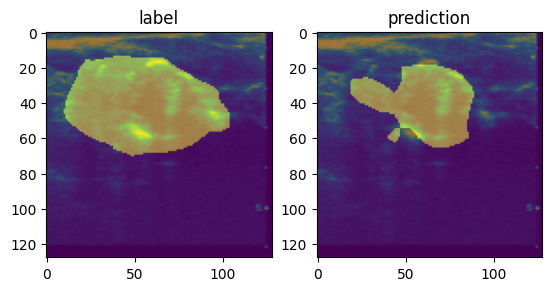

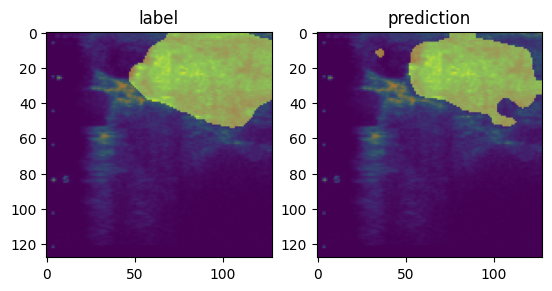

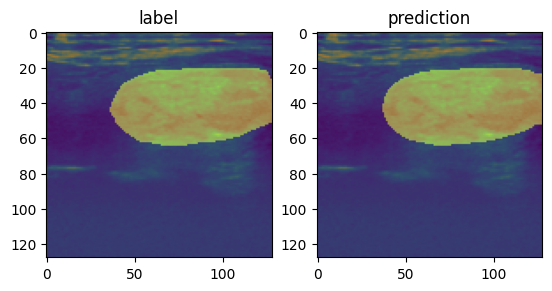

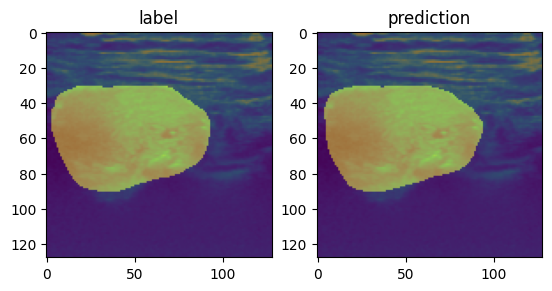

In [17]:
indexs = [9, 15, 2, 8]
for index in indexs:
    
    plt.subplot(1,2,1)
    plt.imshow(image[index][0])
    plt.imshow(mask[index][0], alpha = 0.5)
    plt.title("label")
    
    outputs = outputs>0.5
    plt.subplot(1,2,2)
    plt.imshow(image[index][0])
    plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
    plt.title("prediction")
    plt.show()

In [ ]:
image.shape

In [ ]:
from_dataset.shape

In [15]:
DDTI_area_ratio = []
TN3K_area_ratio = []
DDTI_image_mean = []
TN3K_image_mean = []
for image, mask, seg_type, from_dataset in tqdm(test_dataloader):
    for i in range(image.shape[0]):
        if from_dataset[i]==1:
            # plt.imshow(image[i][0])
            # plt.show()
            DDTI_area_ratio.append(torch.sum(mask[i][0])/(mask.shape[2]*mask.shape[3]))
            DDTI_image_mean.append(torch.mean(image[i][0]))
        elif from_dataset[i]==3:
            TN3K_area_ratio.append(torch.sum(mask[i][0])/(mask.shape[2]*mask.shape[3]))
            TN3K_image_mean.append(torch.mean(image[i][0]))


00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.40it/s]

In [21]:
DDTI_area_ratio = []
TN3K_area_ratio = []
DDTI_image_mean = []
TN3K_image_mean = []
DDTI_image_std = []
TN3K_image_std = []
for image, mask, seg_type, from_dataset in tqdm(test_dataloader):
    for i in range(image.shape[0]):
        if from_dataset[i]==1:
            # plt.imshow(image[i][0])
            # plt.show()
            DDTI_area_ratio.append(torch.sum(mask[i][0])/(mask.shape[2]*mask.shape[3]))
            DDTI_image_mean.append(torch.mean(image[i][0]))
            DDTI_image_std.append(torch.std(image[i][0]))
        elif from_dataset[i]==3:
            TN3K_area_ratio.append(torch.sum(mask[i][0])/(mask.shape[2]*mask.shape[3]))
            TN3K_image_mean.append(torch.mean(image[i][0]))
            TN3K_image_std.append(torch.std(image[i][0]))


00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.60it/s]

In [22]:
np.mean(DDTI_image_std)

0.2088157

In [23]:
np.mean(TN3K_image_std)

0.16833934

In [17]:
DDTI_image_std

[]

In [ ]:
np.mean(DDTI_area_ratio)

In [ ]:
np.mean(TN3K_area_ratio)

In [10]:
np.std(DDTI_image_mean)

0.036692772

In [11]:
np.std(TN3K_image_mean)

0.10103502